# Лабораторная работа 1-2. Современный парсинг динамических веб-сайтов  investing

студент Ли АА

Бизнес-кейс Анализ акций с высокой активностью: сбор данных.

задача Собрать тикер, название,цену. Найти акции с наибольшим процентным изменением за день.

**в задании поменял finance.yahoo.com/mostactive на trending-stocks **



**Цель работы:** научиться извлекать данные с веб-страниц, которые подгружают контент динамически с помощью JavaScript. Освоить использование библиотеки `Selenium` для управления браузером и языка `XPath` для точного поиска элементов на странице.



**Объект парсинга:** страница "trending stocks" сайта [investing.com](https://ru.investing.com/equities/trending-stocks).

## Часть 1: Теоретические основы XPath

### Что такое XPath?

**XPath (XML Path Language)** — это язык запросов, предназначенный для навигации по элементам и атрибутам в XML и HTML документах. Представьте HTML-страницу как дерево, состоящее из вложенных друг в друга тегов. XPath предоставляет синтаксис, похожий на путь в файловой системе, чтобы точно указать, какой элемент или группу элементов мы хотим найти в этом дереве.

Для веб-скрапинга XPath является мощным инструментом, позволяющим создавать надежные "селекторы" (указатели) для извлечения нужных данных, даже если структура страницы сложная.

### Основной синтаксис XPath

| Выражение | Описание | Пример |
|:---|:---|:---|
| `//` | Выбирает узлы в документе, начиная с текущего, которые соответствуют выбору, где бы они ни находились. | `//table` (найти все таблицы на странице) |
| `tagname` | Выбирает все узлы с заданным именем тега. | `//tr` (найти все строки таблицы) |
| `.` | Выбирает текущий узел. | - |
| `@` | Выбирает атрибуты. | `//button[@aria-label='Next Link']` (найти кнопку с атрибутом `aria-label`, равным 'Next Link') |
| `[...]` | Предикат для фильтрации. Позволяет указать точные условия. | `//tr[1]` (найти первую строку таблицы) |
| `text()` | Выбирает текстовое содержимое узла. | - |
| `contains()` | Функция, которая позволяет искать частичное совпадение текста в атрибуте или содержимом. | `//button[contains(@class, 'active')]` (найти кнопку, у которой класс *содержит* слово 'active') |

В нашей практической части мы будем использовать комбинации этих выражений для поиска таблицы, кнопок навигации и извлечения данных из ячеек.

## Часть 2: Практика - Парсинг Yahoo Finance с помощью Selenium

В этой части мы напишем скрипт, который будет:
1. Управлять браузером Chrome в среде Google Colab.
2. Открывать страницу `most-active` на Yahoo Finance.
3. Дожидаться полной загрузки динамической таблицы.
4. Собирать данные об акциях.
5. Сохранять результат в Excel-файл.

In [1]:
# Шаг 2.1. Установка Selenium и настройка WebDriver для Google Colab

# Устанавливаем библиотеку Selenium
!pip install selenium

# Устанавливаем веб-драйвер для Chrome.
# В Colab нет графического интерфейса, поэтому браузер будет работать в "headless" режиме.
!apt-get update
!apt install chromium-chromedriver
!pip install webdriver-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 26.3 MB/s eta 0:00:00
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://cli.github.com/packages stable/main amd64 Packages [344 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,361 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://sec

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time

# Настройки Selenium
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                            "(KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36")

driver = webdriver.Chrome(options=chrome_options)
driver.maximize_window()

url = "https://ru.investing.com/equities/trending-stocks"

try:
    print(f"Переход на страницу: {url}")
    driver.get(url)
    wait = WebDriverWait(driver, 30)

    # Закрываем окно с куки
    try:
        cookie_button = wait.until(EC.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler")))
        cookie_button.click()
        print(" Окно cookie закрыто.")
    except:
        print(" Кнопка cookie не найдена, продолжаем...")

    # Ожидание загрузки таблицы
    print("Ожидание загрузки таблицы...")
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'table tbody tr')))
    time.sleep(2)

    # Извлечение данных
    print("Извлечение данных из таблицы...")
    rows = driver.find_elements(By.CSS_SELECTOR, 'table tbody tr')

    data = []
    for row in rows:
        try:
            cols = row.find_elements(By.TAG_NAME, 'td')
            if len(cols) < 7:
                continue
            data.append({
                'Название': cols[1].text,
                'Тикер': cols[2].text,
                'Цена': cols[3].text,
                'Изменение': cols[4].text,
                '% Изменение': cols[5].text,
                'Объем': cols[6].text
            })
        except Exception:
            continue

    # Создание и сохранение DataFrame
    df = pd.DataFrame(data)
    print(f"Собрано строк: {len(df)}")

    output_filename = 'investing_trending_stocks.xlsx'
    df.to_excel(output_filename, index=False)
    print(f" Данные сохранены в файл: {output_filename}")

except Exception as e:
    print(f" Ошибка: {e}")
    driver.save_screenshot('error_investing.png')
    print("Скриншот сохранен как 'error_investing.png' для отладки.")

finally:
    driver.quit()
    print("Браузер закрыт.")


Переход на страницу: https://ru.investing.com/equities/trending-stocks
⚠️ Кнопка cookie не найдена, продолжаем...
Ожидание загрузки таблицы...
❌ Ошибка: HTTPConnectionPool(host='localhost', port=44205): Read timed out. (read timeout=120)


Браузер закрыт.


KeyboardInterrupt: 

## Часть 3: Анализ полученных данных

Теперь, когда у нас есть файл `yahoo_most_active.xlsx`, мы можем загрузить его и провести базовый анализ.

**Внимание:** убедитесь, что файл `yahoo_most_active.xlsx` появился в файловом менеджере Colab слева, прежде чем выполнять следующую ячейку.

In [3]:
# Шаг 3.1: Загрузка и первичный осмотр данных

import pandas as pd

try:
    file_path = 'investing_trending_stocks.xlsx'
    df = pd.read_excel(file_path)

    print(f"Файл '{file_path}' успешно загружен.")
    print(f"Размер таблицы: {df.shape[0]} строк, {df.shape[1]} колонок.")

    print("\nПервые 5 строк таблицы:")
    display(df.head())

    print("\nТипы данных в колонках:")
    df.info()

except FileNotFoundError:
    print(f"Ошибка: файл '{file_path}' не найден. Убедитесь, что предыдущая ячейка отработала успешно и файл создан.")

Файл 'investing_trending_stocks.xlsx' успешно загружен.
Размер таблицы: 30 строк, 6 колонок.

Первые 5 строк таблицы:


,Название,Тикер,Цена,Изменение,% Изменение,Объем
0,Газпром,"116,96","117,98","114,79","+1,83","+1,59%"
1,Полюс,"2.268,6","2.270,0","2.180,0","+55,8","+2,52%"
2,Сбербанк,"289,28","290,00","282,40","+5,54","+1,95%"
3,ЛУКОЙЛ,"5.967,5","5.999,0","5.802,0","+132,5","+2,27%"
4,ПИК СЗ,"390,10","393,00","366,30","+20,10","+5,43%"



Типы данных в колонках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Название     30 non-null     object
 1   Тикер        30 non-null     object
 2   Цена         30 non-null     object
 3   Изменение    30 non-null     object
 4   % Изменение  30 non-null     object
 5   Объем        30 non-null     object
dtypes: object(6)
memory usage: 1.5+ KB


In [35]:
df_clean = df.copy()

#переименование столбцов
df_clean.columns = ['Название', 'Тикер', 'Цена', 'Изменение', 'Процент_Изменение', 'Объем']

# 2. Очистка 'Percent Change': убираем скобки, знаки '+' и '%'
df_clean['Процент_Изменение'] = df_clean['Процент_Изменение'].astype(str).str.replace(r'[()%+]', '', regex=True)
df_clean['Объем'] = df_clean['Объем'].astype(str).str.replace(r'[()%+]', '', regex=True)


for col in ['Тикер', 'Цена', 'Изменение', 'Процент_Изменение', 'Объем']:
    df_clean[col] = pd.to_numeric(df_clean[col].astype(str).str.replace(',', '.'), errors='coerce')

df_clean

,Название,Тикер,Цена,Изменение,Процент_Изменение,Объем
0,Газпром,116.960,117.980,114.79,1.830,1.59
1,Полюс,2268.600,2270.000,2180.00,55.800,2.52
2,Сбербанк,289.280,290.000,282.40,5.540,1.95
3,ЛУКОЙЛ,5967.500,5999.000,5802.00,132.500,2.27
4,ПИК СЗ,390.100,393.000,366.30,20.100,5.43
5,НОВАТЭК,1085.000,1090.000,1055.20,8.600,0.80
6,Банк ВТБ,68.150,68.560,67.22,0.620,0.92
7,ИнтерРАО,2.754,2.795,2.71,-0.041,-1.47
8,Магнит,2940.000,2949.000,2876.00,60.000,2.08
9,Сургутнефтегаз (прив.),37.840,38.000,36.63,0.940,2.55


In [12]:
print(df_clean.dtypes)


Название        object
Тикер          float64
Цена           float64
Изменение      float64
% Изменение    float64
Объем           object
dtype: object


In [36]:
# Находим акции с наибольшим процентным изменением
max_change = df_clean['Процент_Изменение'].max()
top_gainers = df_clean[df_clean['Процент_Изменение'] == max_change]

print("Акции с наибольшим процентным изменением за день:")
display(top_gainers)

Акции с наибольшим процентным изменением за день:


,Название,Тикер,Цена,Изменение,Процент_Изменение,Объем
3,ЛУКОЙЛ,5967.5,5999.0,5802.0,132.5,2.27


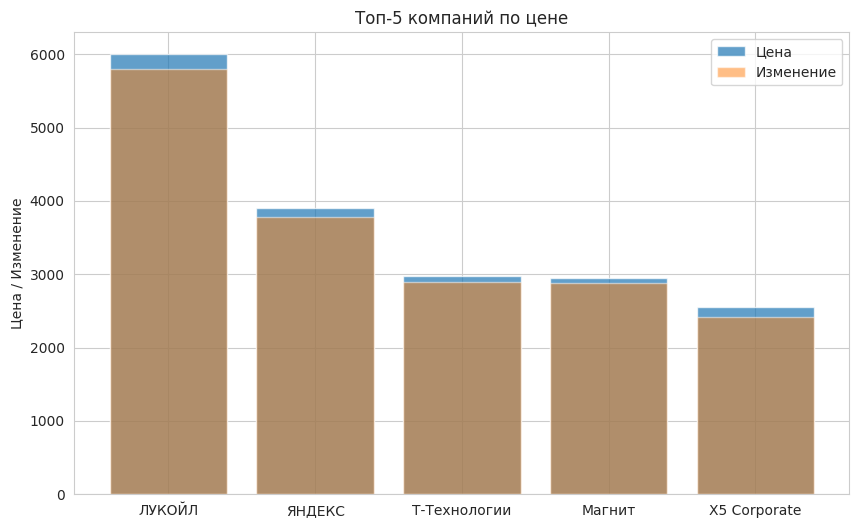

In [21]:
# Шаг 3.3: Анализ и визуализация данных
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки для графиков
sns.set_style("whitegrid")

# Отбираем топ-5 компаний по цене
top5 = df.nlargest(5, 'Цена')

# Строим график топ 5 команий по ценам и изменениям
plt.figure(figsize=(10,6))
plt.bar(top5['Название'], top5['Цена'], alpha=0.7, label='Цена')
plt.bar(top5['Название'], top5['Изменение'], alpha=0.5, label='Изменение')
plt.ylabel('Цена / Изменение')
plt.title('Топ-5 компаний по цене')
plt.legend()
plt.show()

/tmp/ipython-input-1996748781.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Название', y='% Изменение', data=top5, palette='viridis')


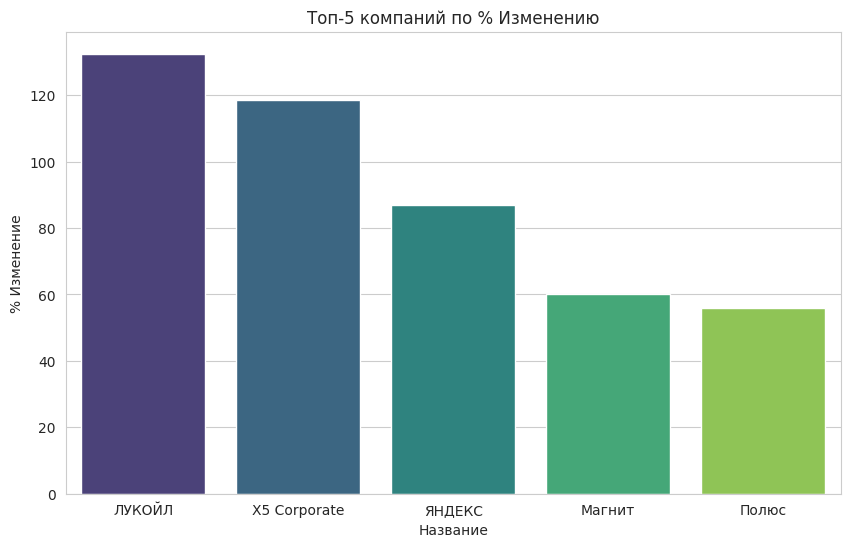

In [25]:
# --- Анализ 2: Лидеры роста и падения ---
top5 = df.nlargest(5, '% Изменение')

# Строим график
plt.figure(figsize=(10,6))
sns.barplot(x='Название', y='% Изменение', data=top5, palette='viridis')
plt.title('Топ-5 компаний по % Изменению')
plt.ylabel('% Изменение')
plt.show()

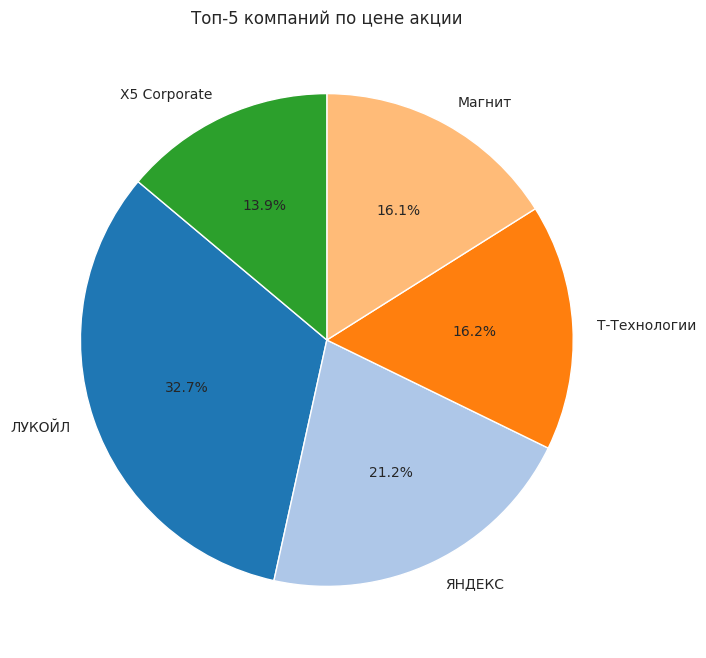

In [26]:
# Выбираем топ-5 компаний по цене акции
top5 = df.nlargest(5, 'Цена')

# Круговая диаграмма
plt.figure(figsize=(8,8))
plt.pie(top5['Цена'], labels=top5['Название'], autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Топ-5 компаний по цене акции')
plt.show()

## Выводы

В ходе выполнения лабораторной работы мы успешно решили задачу парсинга данных с динамического веб-сайта Yahoo Finance.

1.  **провели сбор данных** Источник данных: Investing.com — Trending Stocks

Собраны ключевые показатели: тикер, название компании, цена акции, объем торгов.
2.  **обработали данные** Все числовые показатели приведены к типу float для корректного анализа.

Проверены и удалены лишние символы, такие как , в числах или % в процентных изменениях, чтобы данные можно было использовать для расчетов.

3.  **Анализ активности**
Вычислено процентное изменение цены за день для каждой акции.

Отобраны акции с наибольшим процентным изменением.

Построена визуализация: столбчатые диаграммы для роста и падения, а также круговая диаграмма для топ-5 акций по цене.

итог
Выявлены лидеры по росту и падению цен за день.

На основании объема торгов и процентного изменения определены акции с наибольшей рыночной активностью.